In [1]:
%config Completer.use_jedi = False

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from utils import *

In [3]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data preparation

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [6]:
train_images.shape

(50000, 32, 32, 3)

In [7]:
test_images.shape

(10000, 32, 32, 3)

In [8]:
train_images.astype('float32') 
test_images.astype('float32') 

train_images = train_images/255.
test_images = test_images/255.

In [9]:
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

# Vanilla network

In [10]:
def build_vanilla_model(shape, class_num):
    # specify the inputs for the feature extractor network
    inputs = Input(shape)

    x = Conv2D(32, (3, 3), activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (2, 2), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (2, 2), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(class_num, activation='softmax')(x)

    # build the model
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

### model on the whole dataset

learning

In [11]:
# model = build_vanilla_model(train_images[0].shape, 10)

In [12]:
# history = model.fit(train_images, train_labels_cat, epochs=200, batch_size=512, 
#                     validation_data=(test_images, test_labels_cat))

In [13]:
# print_history_chart(history)

In [14]:
# model.save('vanilla_cifar10.h5')

evaluation

In [15]:
model = tf.keras.models.load_model("vanilla_cifar10.h5")

In [16]:
results_vanilla_full = full_evaluate(model, test_images, test_labels)

accuracy_score: 0.789
f1_score_macro: 0.7843261383766078
f1_score_weighted: 0.7936738616233923


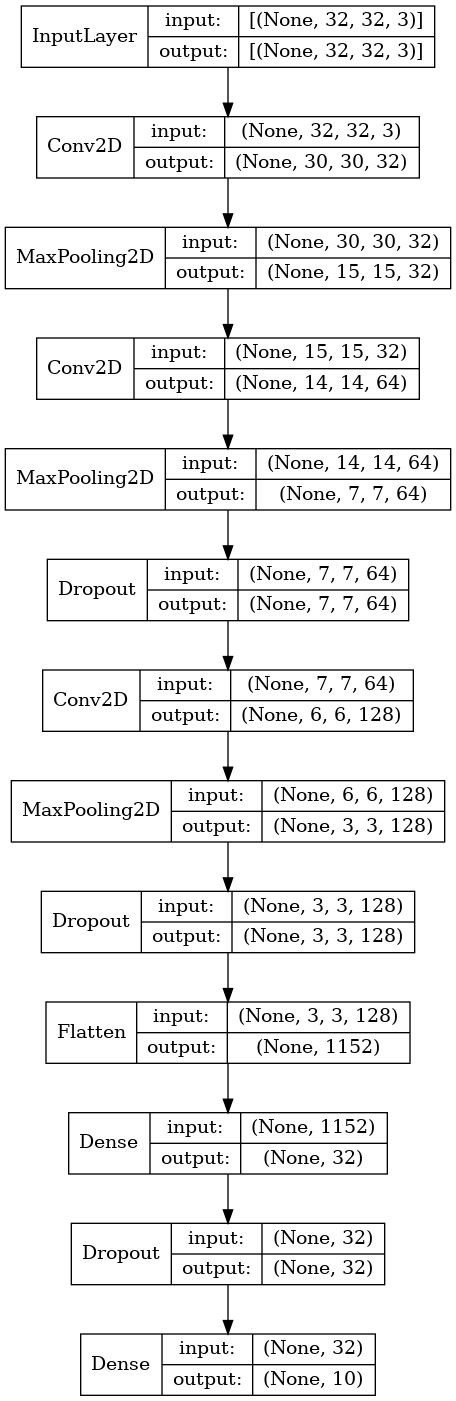

In [18]:
plot_model(model, show_shapes=True, show_layer_names=False)

### models on the smaller datasets

#### 50% of the training data

learning

In [19]:
# model = build_vanilla_model(train_images[0].shape, 10)

In [20]:
# train_images_50p = train_images[:len(train_images)//2]
# train_labels_cat_50p = train_labels_cat[:len(train_labels_cat)//2]

In [21]:
# history = model.fit(train_images_50p, train_labels_cat_50p, epochs=300, batch_size=512, 
#                     validation_data=(test_images, test_labels_cat))

In [22]:
# print_history_chart(history)

In [23]:
# model.save('vanilla_50p_cifar10.h5')

evaluation

In [24]:
model = tf.keras.models.load_model("vanilla_50p_cifar10.h5")

In [25]:
results_vanilla_50p = full_evaluate(model, test_images, test_labels)

accuracy_score: 0.7546
f1_score_macro: 0.7541098874413018
f1_score_weighted: 0.7550901125586983


#### 10% of the training data

learning

In [26]:
# model = build_vanilla_model(train_images[0].shape, 10)

In [27]:
# train_images_10p = train_images[:len(train_images)//10]
# train_labels_cat_10p = train_labels_cat[:len(train_labels_cat)//10]

In [28]:
# history = model.fit(train_images_10p, train_labels_cat_10p, epochs=400, batch_size=512, 
#                     validation_data=(test_images, test_labels_cat))

In [29]:
# print_history_chart(history)

In [30]:
# model.save('vanilla_10p_cifar10.h5')

evaluation

In [31]:
model = tf.keras.models.load_model("vanilla_10p_cifar10.h5")

In [32]:
results_vanilla_10p = full_evaluate(model, test_images, test_labels)

accuracy_score: 0.6355
f1_score_macro: 0.6314960493654187
f1_score_weighted: 0.6395039506345813


# Siemese network

In [33]:
def build_siamese_vanilla_model(shape, class_num):
    inputs1 = Input(shape)
    inputs2 = Input(shape)
    
    def one_side(inputs):
        x = Conv2D(32, (3, 3), activation="relu")(inputs)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(64, (2, 2), activation="relu")(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(128, (2, 2), activation="relu")(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Dropout(0.2)(x)

        x = Flatten()(x)

        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        return x
    
    x1 = one_side(inputs1)
    x2 = one_side(inputs2)
    
    x = concatenate([x1, x2])
    
    outputs = Dense(class_num, activation='softmax')(x)

    # build the model
    model = Model([inputs1, inputs2], outputs)
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [34]:
def make_pairs(labels):
    samples = {a: list(filter(lambda x: True if x[1]==a else False, enumerate(labels))) for a in np.unique(labels)}
    labels2 = []
    for l in labels:
        labels2.append(random.choice(samples[l[0]])[0])
    return labels2

### model on the whole datasets

learning

In [35]:
# model = build_siamese_vanilla_model(train_images[0].shape, 10)

In [36]:
# idx2 = make_pairs(train_labels)

# y = np.concatenate([train_labels,train_labels[idx2]])
# X1 = np.concatenate([train_images,train_images])
# X2 = np.concatenate([train_images,train_images[idx2]])

# y = to_categorical(y)

In [37]:
# history = model.fit([X1, X2], y, epochs=200, batch_size=512, shuffle=True,
#          validation_data=([test_images, test_images], test_labels_cat))


In [38]:
# print_history_chart(history)

In [39]:
# model.save('siamese_vanilla_cifar10.h5')

evaluate

In [40]:
model = tf.keras.models.load_model("siamese_vanilla_cifar10.h5")


In [41]:
results_siamese_vanilla = full_evaluate(model, [test_images, test_images], test_labels)

accuracy_score: 0.8133
f1_score_macro: 0.811662988993892
f1_score_weighted: 0.8149370110061082


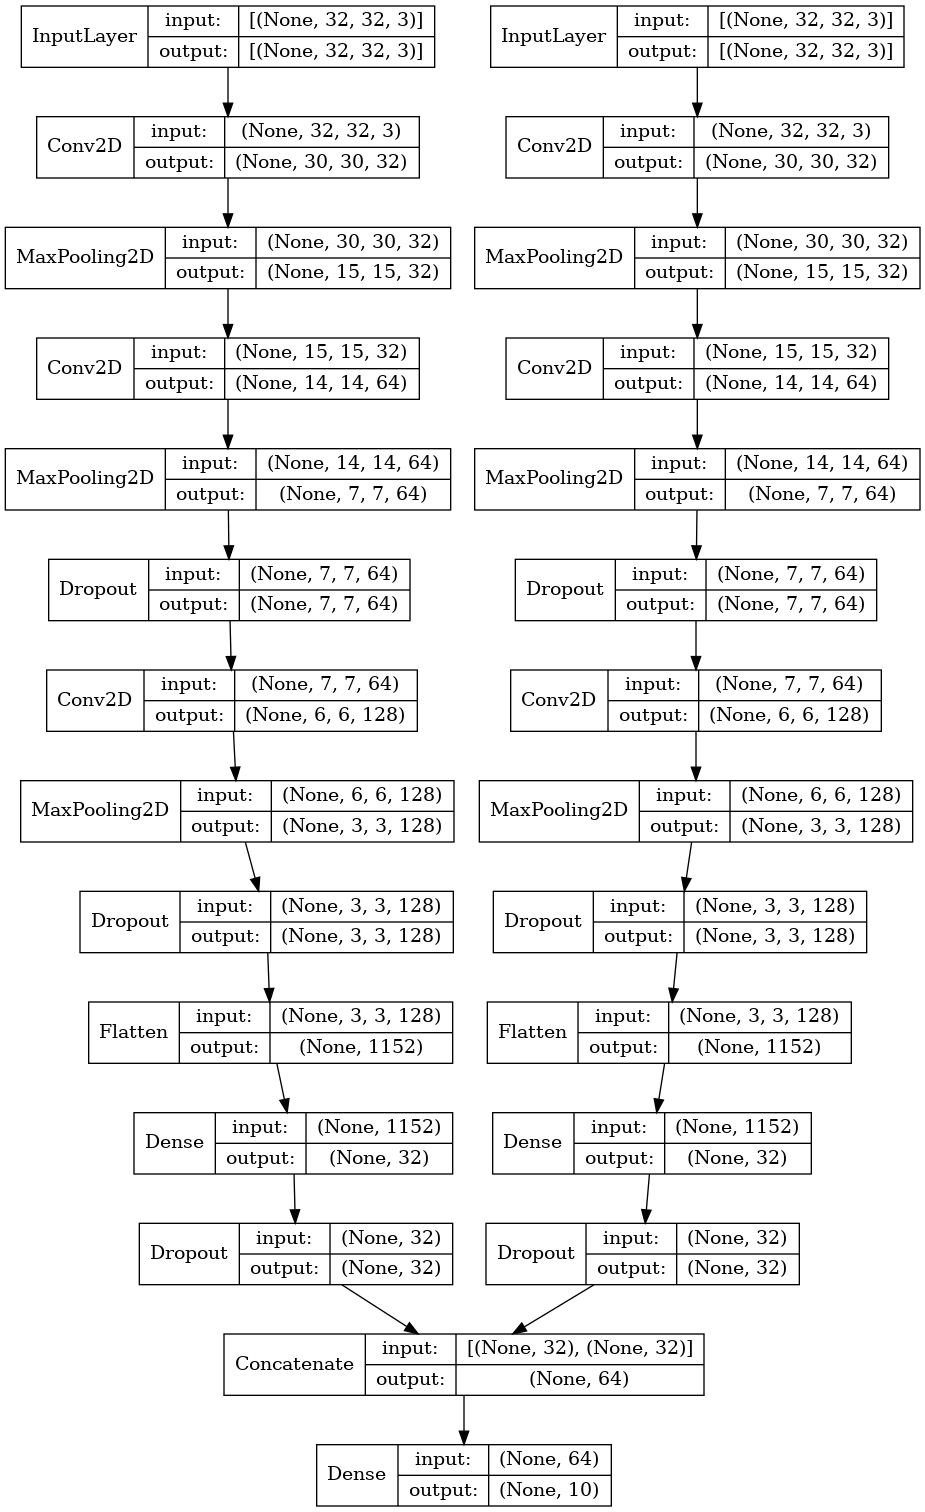

In [56]:
plot_model(model, show_shapes=True, show_layer_names=False)

### models on the smaller datasets

#### 50% of the taining data

learning

In [42]:
model = build_siamese_vanilla_model(train_images[0].shape, 10)

In [43]:
train_images_50p = train_images[:len(train_images)//2]
train_labels_50p = train_labels[:len(train_labels)//2]

In [44]:
# idx2 = make_pairs(train_labels_50p)
# idx3 = make_pairs(train_labels_50p)

# y = np.concatenate([train_labels_50p, train_labels_50p[idx2], train_labels_50p[idx3]])
# X1 = np.concatenate([train_images_50p, train_images_50p, train_images_50p])
# X2 = np.concatenate([train_images_50p, train_images_50p[idx2], train_images_50p[idx3]])
# y = to_categorical(y)

In [45]:
# history = model.fit([X1, X2], y, epochs=300, batch_size=512, shuffle=True,
#          validation_data=([test_images, test_images], test_labels_cat))

In [46]:
# model.save('siamese_vanilla_50p_cifar10.h5')

evaluate

In [47]:
model = tf.keras.models.load_model("siamese_vanilla_50p_cifar10.h5")

In [48]:
results_siamese_vanilla_50p = full_evaluate(model, [test_images, test_images], test_labels)

accuracy_score: 0.7758
f1_score_macro: 0.7747984199841977
f1_score_weighted: 0.7768015800158022


#### 10% of the taining data

learning

In [49]:
# model = build_siamese_vanilla_model(train_images[0].shape, 10)

In [50]:
# train_images_10p = train_images[:len(train_images)//10]
# train_labels_10p = train_labels[:len(train_labels)//10]

In [51]:
# idx2 = make_pairs(train_labels_10p)
# idx3 = make_pairs(train_labels_10p)
# idx4 = make_pairs(train_labels_10p)
# idx5 = make_pairs(train_labels_10p)

# y = np.concatenate([train_labels_10p, train_labels_10p[idx2], train_labels_10p[idx3], train_labels_10p[idx4],
#                    train_labels_10p[idx5]])
# X1 = np.concatenate([train_images_10p, train_images_10p, train_images_10p, train_images_10p, train_images_10p])
# X2 = np.concatenate([train_images_10p, train_images_10p[idx2], train_images_10p[idx3], train_images_10p[idx4],
#                     train_images_10p[idx5]])
# y = to_categorical(y)

In [52]:
# history = model.fit([X1, X2], y, epochs=300, batch_size=512, shuffle=True,
#          validation_data=([test_images, test_images], test_labels_cat))

In [53]:
# model.save('siamese_vanilla_10p_cifar10.h5')

evaluate

In [54]:
model = tf.keras.models.load_model("siamese_vanilla_10p_cifar10.h5")

In [55]:
results_siamese_vanilla_10p = full_evaluate(model, [test_images, test_images], test_labels)

accuracy_score: 0.6446
f1_score_macro: 0.6422821825355671
f1_score_weighted: 0.6469178174644329
